# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [0]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [0]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
## 超參數設定
LEARNING_RATE = [1e-2, 1e-3, 1e-4]
EPOCHS = 50
BATCH_SIZE = 256
OPTIMIZER = ['SGD','RMSprop','AdaGrad','Adam']


In [0]:
results = {}
"""
使用迴圈，建立不同 Learning與Optimizer的模型並訓練
"""
for lr in LEARNING_RATE:
  for opt in OPTIMIZER:
      keras.backend.clear_session() # 把舊的 Graph 清掉
      print("Learning Rate = %.2f" % (lr))
      print("Optimizer = %s" %(opt))
      model = build_mlp(input_shape=x_train.shape[1:])
      model.summary()
      if opt == 'SGD':
        optimizer = keras.optimizers.SGD(lr=lr, momentum=0.0, decay=0.0, nesterov=False)
      if opt == 'RMSprop':
        optimizer = keras.optimizers.RMSprop(lr=lr, rho=0.9, epsilon=None, decay=0.0)
      if opt == 'AdaGrad':
        optimizer = keras.optimizers.Adagrad(lr=lr, epsilon=None, decay=0.0)
      if opt == 'Adam':
        optimizer = keras.optimizers.Adam(lr= lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

      model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

      model.fit(x_train, y_train, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                validation_data=(x_test, y_test), 
                shuffle=True)
      
      # Collect results
      train_loss = model.history.history["loss"]
      valid_loss = model.history.history["val_loss"]
      train_acc = model.history.history["acc"]
      valid_acc = model.history.history["val_acc"]
      
      exp_name_tag = "lr:%f-opt:%s"%(lr, opt)
      results[exp_name_tag] = {'train-loss': train_loss,
                              'valid-loss': valid_loss,
                              'train-acc': train_acc,
                              'valid-acc': valid_acc}

Learning Rate = 0.01
Optimizer = SGD


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadca

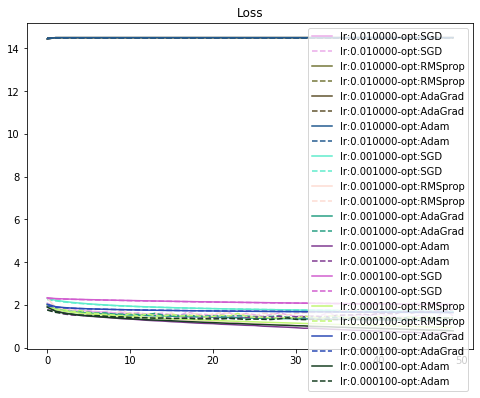

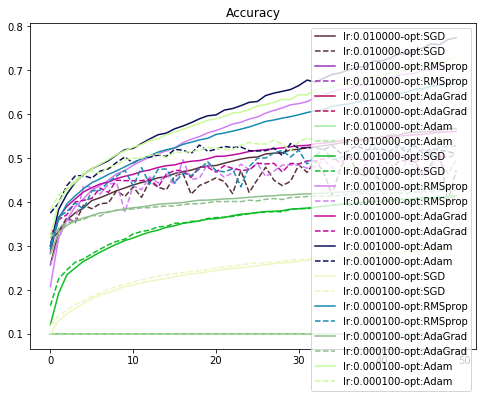

In [13]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    color = np.random.rand(3)
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color)
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color)
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    color = np.random.rand(3)
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color)
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color)
plt.title("Accuracy")
plt.legend()
plt.show()